In [1]:
import pandas as pd
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.cluster import (KMeans, AgglomerativeClustering, 
                             AffinityPropagation, SpectralClustering)
from scipy.cluster.hierarchy import dendrogram, linkage

import scikitplot as skp

%matplotlib inline

In [2]:
# read the pickled data
pickle_data = open(os.path.join(os.getcwd(), '..', 'data', 'processed', 'clean_data.pickle'), 'rb')
data = pickle.load(pickle_data)
# rename the columns for plotting
data.columns = ['Year', 'Income Index', 'Education Index', 'Percent White',
                'Rent Index', 'Value Index', 'Percent Employed']
# first column is year, which I don't want to mess with
cols = data.columns[1:]

## Standardize the Data
After some testing, I found that the RobustScaler standardization technique performs better for this dataset due to its robust handling of outliers.

In [3]:
# create instance of StandardScaler class
# ss = StandardScaler()
ss = RobustScaler()
# fit and transform the data and put back into a dataframe
data_ss = pd.DataFrame(ss.fit_transform(data[cols]), index=data.index, columns=cols)

## Create Decompositions for Plotting

In [4]:
# create instance of PCA class
pca = PCA()
# fit and transform the data and put back into dataframe
data_pca = pd.DataFrame(pca.fit_transform(data_ss), index=data.index)
# rename the columns
data_pca.columns = ['pca{}'.format(i) for i in range(1, 7)]

In [5]:
%%time

# create tsne instance
tsne = TSNE(n_components=2, init='pca')
# fit and transform the scaled data and put back into a dataframe
data_tsne = pd.DataFrame(tsne.fit_transform(data_ss), index=data.index)
# rename the columns
data_tsne.columns = ['tsne1', 'tsne2']

CPU times: user 1min 8s, sys: 5.08 s, total: 1min 13s
Wall time: 1min 12s


# Clustering

In [6]:
# create a dictionary to hold silhouette score results
sil = {}

## Cluster Plotting Function

In [66]:
def plot_clusters(labels, mod_name, pref=None):
    '''
    plot the kmeans clustering results on the first two principal components

    km is the kmeans model object
    '''
    # set up colors first
    cmap = plt.cm.tab10_r
    colors = cmap.colors
    # create the figure and axes
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    # now plot each point and color by cluster
    for cn in np.unique(labels):
        axes[0].scatter(data_pca[labels == cn]['pca1'],
                        data_pca[labels == cn]['pca2'],
                        c=colors[cn], alpha=0.5, marker='.')
        axes[1].scatter(data_tsne[labels == cn]['tsne1'],
                        data_tsne[labels == cn]['tsne2'],
                        c=colors[cn], alpha=0.5, marker='.')
    # turn off tick labels and set labels and titles
    axes[0].set(xticklabels=[], yticklabels=[],
                xlabel='Principal Component 1', 
                ylabel='Principal Component 2',
                title='Clusters in PCA Space')
    axes[1].set(xticklabels=[], yticklabels=[],
                xlabel='tSNE Component 1',
                ylabel='tSNE Component 2',
                title='Clusters in tSNE Space')
    # now plot the silhouette analysis on the right axis
    skp.metrics.plot_silhouette(data_ss, labels, ax=axes[2], cmap=cmap)
    if pref is None:
        fig.suptitle('{} - {} Clusters'.format(mod_name, len(np.unique(labels))), 
                          y=1.1, fontsize=18)
    else:
        fig.suptitle('{} - {} Clusters - Preference = {}'
                          .format(mod_name, len(np.unique(labels)), pref),
                          y=1.1, fontsize=18)
    fig.tight_layout()
    
    return fig

## KMeans

CPU times: user 16.3 s, sys: 722 ms, total: 17 s
Wall time: 16.8 s


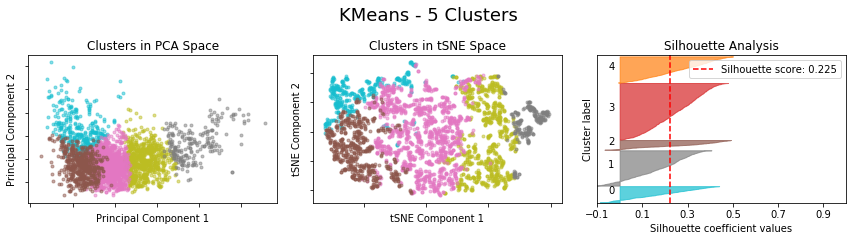

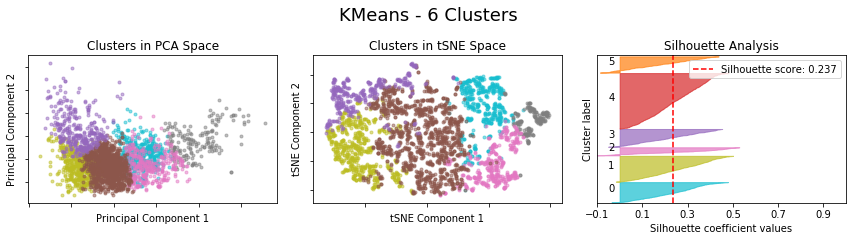

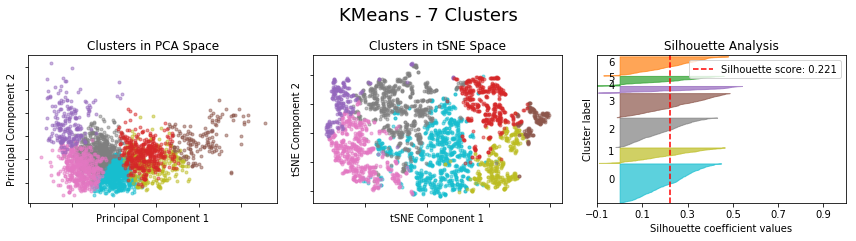

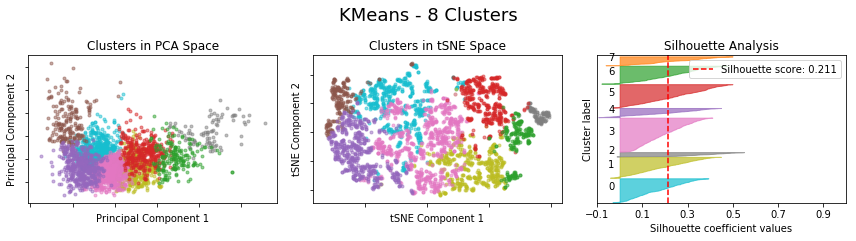

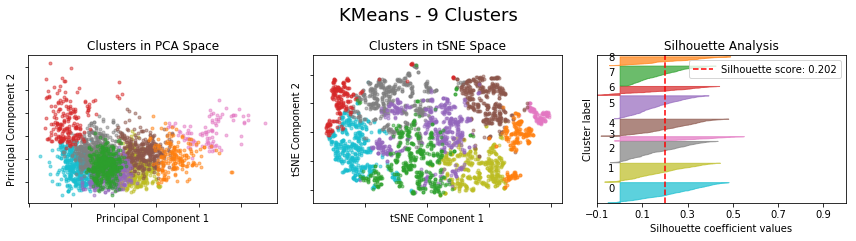

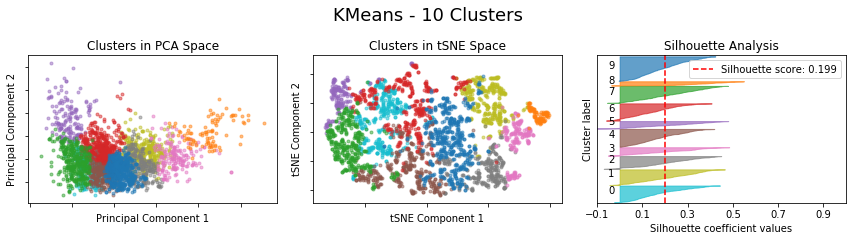

In [65]:
%%time

# create instance of KMEans class
kmeans = KMeans()
# silhouette score and within clusters sum of squares error
sil['kmeans'] = []
wcss = []
# loop 2-10 clusters to make elbow plot and silhouette score plot
for i in range(5, 11):
    # set number of clusters
    kmeans.n_clusters = i
    # fit the model
    kmeans.fit(data_ss)
    # append the wcss and sil scores
    wcss.append(kmeans.inertia_)
    sil['kmeans'].append(skp.metrics.silhouette_score(data_ss, kmeans.labels_))
    # use the plot_kmeans function to plot clusters and silhouette analysis
    fig = plot_clusters(kmeans.labels_, 'KMeans')
    _ = fig.savefig('../figures/kmeans_{}_clusters.png'.format(i), dpi=500, transparent=True, 
                    bbox_inches='tight')

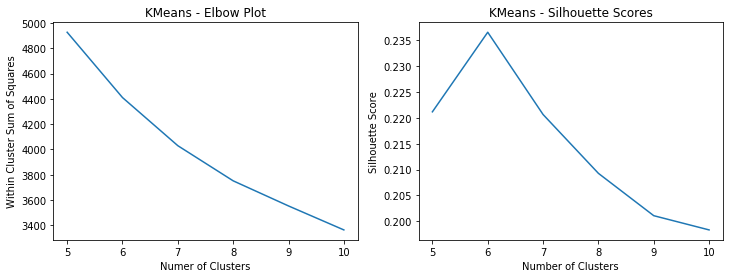

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

_ = axes[0].plot(range(5, 11), wcss)
_ = axes[0].set(xlabel='Numer of Clusters', 
                ylabel='Within Cluster Sum of Squares',
                title="KMeans - Elbow Plot")

_ = axes[1].plot(range(5, 11), sil['kmeans'])
_ = axes[1].set(xlabel='Number of Clusters',
                ylabel='Silhouette Score',
                title='KMeans - Silhouette Scores')

## Hierarchical Agglomerative Clustering

CPU times: user 16.5 s, sys: 787 ms, total: 17.3 s
Wall time: 17.1 s


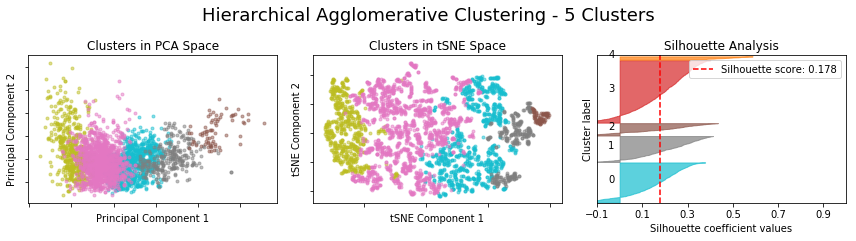

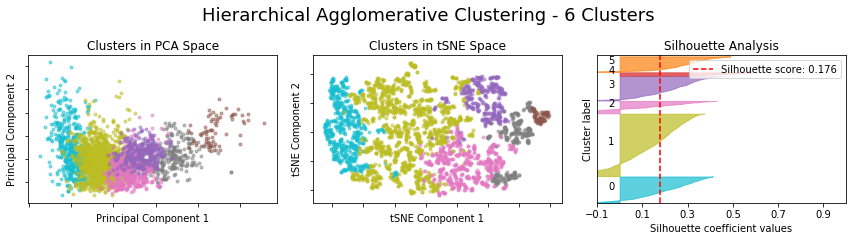

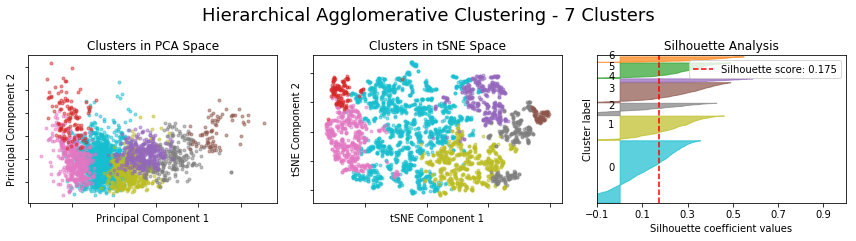

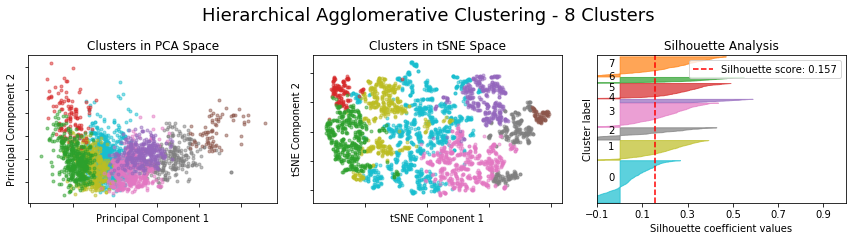

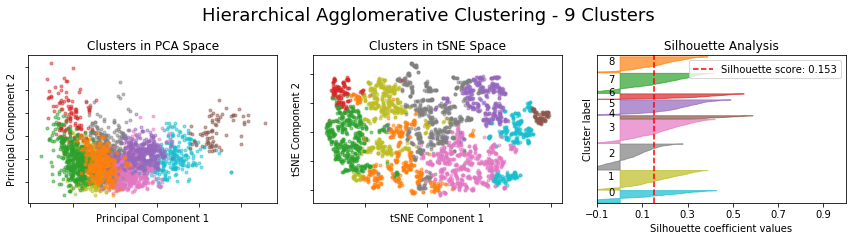

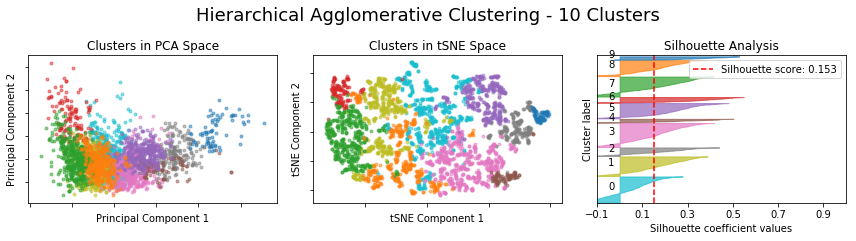

In [67]:
%%time

link = 'ward'

hac = AgglomerativeClustering(linkage=link)

sil['hac'] = []

for i in range(5, 11):
    hac.n_clusters = i
    hac.fit(data_ss)
    sil['hac'].append(skp.metrics.silhouette_score(data_ss, hac.labels_))
    data_pca['clusters'] = hac.labels_
    fig = plot_clusters(hac.labels_, 'Hierarchical Agglomerative Clustering')
    _ = fig.savefig('../figures/agglom_{}_clusters.png'.format(i), dpi=500, transparent=True,
                   bbox_inches='tight')

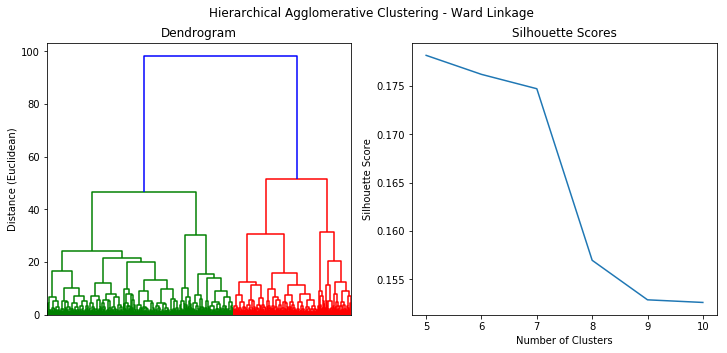

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

dend = dendrogram(linkage(data_ss, method=link), ax=axes[0])
_ = axes[0].set(xticklabels=[])
_ = axes[0].set(ylabel='Distance (Euclidean)', 
                title='Dendrogram')

_ = axes[1].plot(range(5, 11), sil['hac'])
_ = axes[1].set(xlabel='Number of Clusters', ylabel='Silhouette Score',
                title='Silhouette Scores')

_ = fig.suptitle('Hierarchical Agglomerative Clustering - Ward Linkage')

## Affinity Propagation

CPU times: user 32.5 s, sys: 774 ms, total: 33.3 s
Wall time: 33.3 s


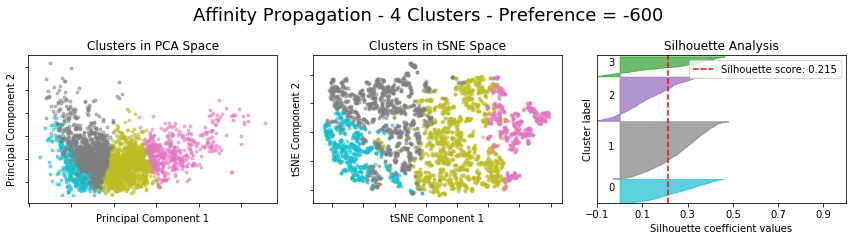

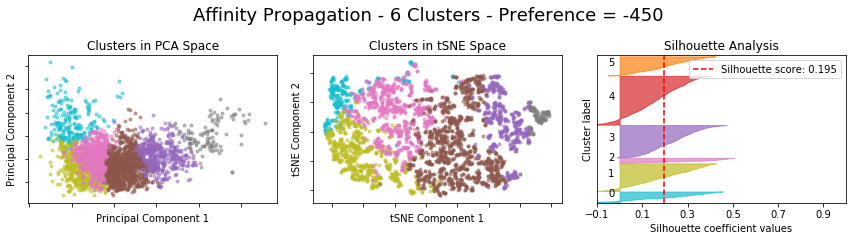

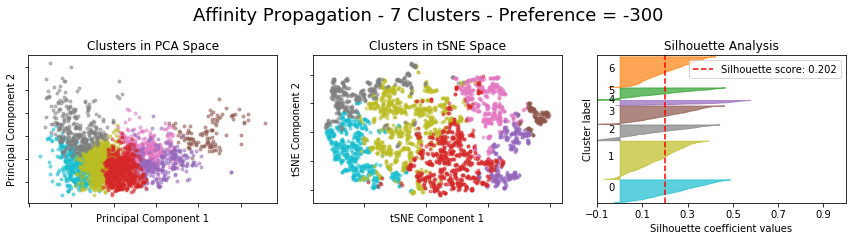

In [68]:
%%time

affin = AffinityPropagation(damping=0.9)

sil['affin'] = [[], []]
nc = []
prefs = [-600, -450, -300]

for pref in prefs:
    affin.preference = pref
    affin.fit(data_ss)
    sil['affin'][0].append(skp.metrics.silhouette_score(data_ss, affin.labels_))
    sil['affin'][1].append(len(np.unique(affin.labels_)))
    nc.append(len(np.unique(affin.labels_)))
    fig = plot_clusters(affin.labels_, 'Affinity Propagation', pref=pref)
    _ = fig.savefig('../figures/affin_{}_pref.png'.format(pref), dpi=500, transparent=True,
                   bbox_inches='tight')

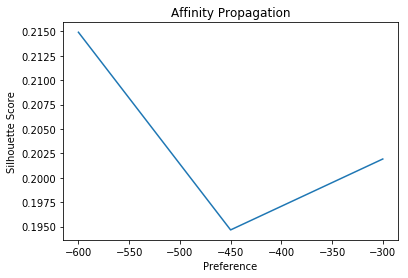

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

_ = ax.plot(prefs, sil['affin'][0])
_ = ax.set(xlabel='Preference', ylabel='Silhouette Score',
           title='Affinity Propagation')

## Spectral Clustering

CPU times: user 27.6 s, sys: 1.1 s, total: 28.7 s
Wall time: 18.8 s


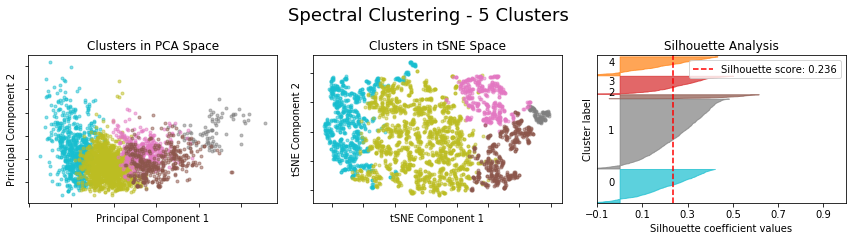

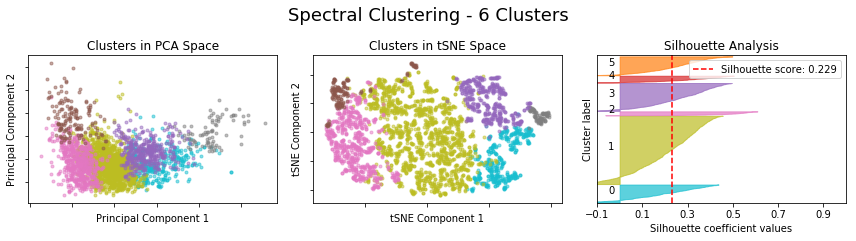

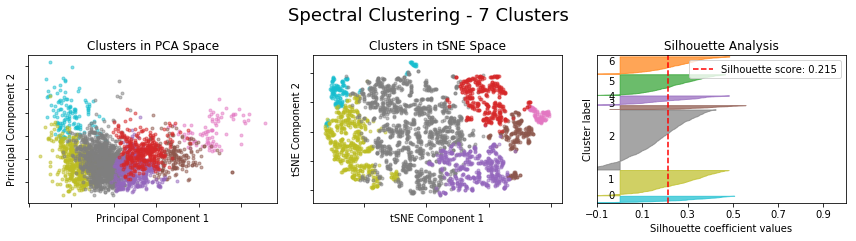

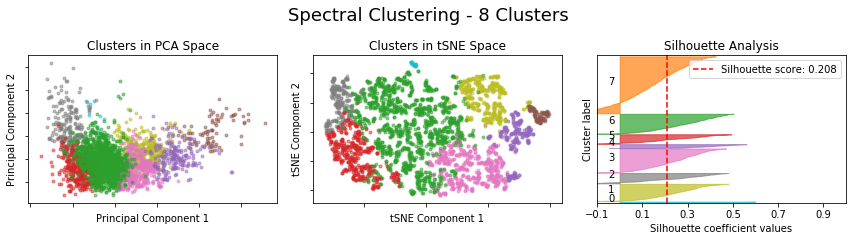

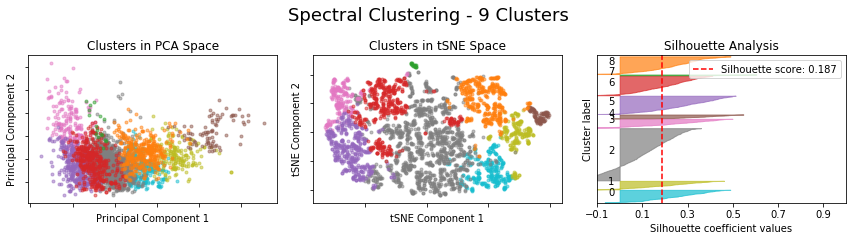

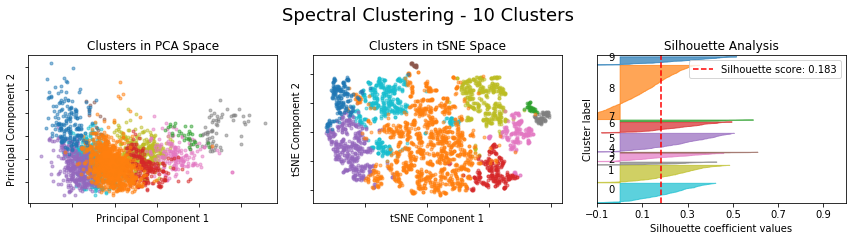

In [69]:
%%time

sil['spec'] = []

sc = SpectralClustering(eigen_solver='arpack', affinity='nearest_neighbors')

for i in range(5, 11):
    sc.n_clusters=i
    sc.fit(data_ss)
    sil['spec'].append(skp.metrics.silhouette_score(data_ss, sc.labels_))
    fig = plot_clusters(sc.labels_, 'Spectral Clustering')
    _ = fig.savefig('../figures/spectral_{}_clusters.png'.format(i), dpi=500, transparent=True,
                   bbox_inches='tight')

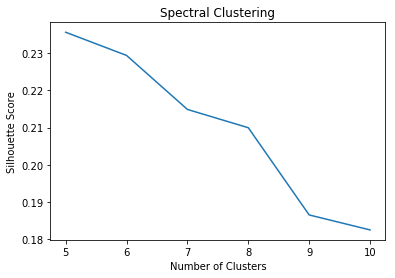

In [45]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

_ = ax.plot(range(5, 11), sil['spec'])
_ = ax.set(xlabel='Number of Clusters', ylabel='Silhouette Score',
           title='Spectral Clustering')

## Comparing Silhouette Scores

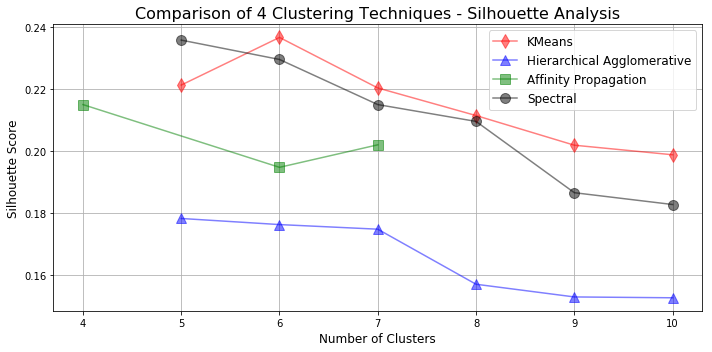

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

for key, marker, color in zip(sil.keys(), ['d', '^', 's', 'o'],
                              ['r', 'b', 'g', 'k']):
    if key == 'affin':
        _ = ax.plot(sil[key][1], sil[key][0], marker=marker, c=color, alpha=0.5, label=key, markersize=10)
    else:
        _ = ax.plot(range(5, 11), sil[key], marker=marker, c=color, alpha=0.5, label=key, markersize=10)
_ = ax.legend(['KMeans', 'Hierarchical Agglomerative', 'Affinity Propagation', 'Spectral'], fontsize=12)

_ = ax.set_xlabel('Number of Clusters', fontsize=12)
_ = ax.set_ylabel('Silhouette Score', fontsize=12)
_ = ax.set_title('Comparison of 4 Clustering Techniques - Silhouette Analysis', fontsize=16)
_ = ax.grid()

fig.tight_layout()

_ = fig.savefig('../figures/silhouette_comparison.png', dpi=500, transparent=True)

I want sufficient amount of clusters to be able to show movement between clusters, which will be a proxy for neighborhood level socioeconomic change. Because of this I've decided to use at least 5 clusters (even though the silhouette score for 3 and 4 clusters is somewhat higher). Using these conditions, there are two candidates, Spectral Clustering with 5 clusters and KMeans with 6 clusters. The silhouette score for the two candidates is 0.236 and 0.237 respectively. Not a big difference, but a difference nonetheless. So **I'll be using KMeans with 6 clusters for the rest of this project.**